# Assignment 1

## Instructions
This is an individual assignment. You are not allowed to discuss the problems with other students.

- Part of this assignment will be autograded by Gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want. We provide some tests which you can use to check that your code will execute properly on Gradescope. These are **not** meant to check the correctness of your answers. We encourage you to write your own tests for this.
- All your code, analysis, graphs, explanations, etc. should be done in this same notebook.
- Please make sure to execute all the cells before you export the notebook to a PDF and submit it to Gradescope. You will not get points for the plots if they are not generated already.
- If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

Before starting the assignment, make sure that you have downloaded all the data and tests related for the assignment and put them in the appropriate locations. If you run the next cell, we will set this all up automatically for you in a dataset called public, which will contain both the data and tests you use.

**Warning**: Throughout the assignment, you will be asked to implement certain algorithms and find optimal values. In the solution you submit, do not simply call a library function which performs the entire algorithm for you, this is forbidden, as it would obviously defeat the purpose. For example, if you were asked to implement the linear regression, do not simply call an outside package for help.

**When Submitting to GradeScope**: Be sure to
1) Submit a `.ipynb` notebook to the `Assignment 1 - Practial` section on Gradescope.
2) Submit a `pdf` version of the notebook to the `Assignment 1 - Analysis` entry.

**Note**: You can choose to submit responses in either English or French.

In [159]:
!pip install -q otter-grader
!git clone https://github.com/chandar-lab/INF8245e-assignments-2023.git public

fatal: destination path 'public' already exists and is not an empty directory.


In [160]:
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/a1/tests')

In [161]:
# DO NOT RE-SEED ANYWHERE OTHERWISE YOUR IMPLEMENTATION MAY FAIL SOME UNIT TESTS
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

np.random.seed(8245)
%matplotlib inline

working_dir = './public/a1' # CHANGE THIS TO THE MAIN ASSIGNMENT DIRECTORY

## **Question 1: Linear Regression (30 points)**
In this question, you will take a simple dataset and implement linear and ridge regression by solving for their analytical solutions. You will then perform a simple hyperparameter search to determine regression co-efficients that best suit the data.

We'll be using the Boston Housing Dataset, which you can find out more about [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). The goal is to determine the best way to weight different features of houses to determine the price it was sold for.

The following cell is just for loading the data properly in the format you need. In this case, we load our data as a design matrix $X$ where
$$
X = \begin{bmatrix} x_{11} & \cdots & x_{1d} \\ \vdots & \ddots & \vdots \\ x_{n1} & \cdots & x_{nd} \end{bmatrix}
$$ where each row is an instance of the data. Meanwhile, the targets $y$ is loaded as a single column vector where the $i$-th entry corresponds to the target for the $i$-th row in $X$.

In [162]:
def load_linear_regression_data(working_dir):
    test_inputs = np.genfromtxt(working_dir + '/data/housing_X_test.csv', delimiter=',')
    test_targets = np.genfromtxt(working_dir + '/data/housing_y_test.csv', delimiter=',')
    train_inputs = np.genfromtxt(working_dir + '/data/housing_X_train.csv', delimiter=',')
    train_targets = np.genfromtxt(working_dir + '/data/housing_y_train.csv', delimiter=',')

    return train_inputs.T, train_targets.reshape((train_targets.shape[0], 1)), test_inputs.T, test_targets.reshape((test_targets.shape[0], 1))

X_tr, y_tr, X_te, y_te = load_linear_regression_data(working_dir)

### Q1a) **(10 points)**

The following functions are helper functions meant to help with processing all the data and running your functions. However they will be important for the rest of your assignment so be sure to implement them correctly.

_Type your answer here, replacing this text._

In [163]:
def create_inputs_with_bias(X: np.ndarray) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input

    Returns:
        X_new (np.ndarray): Input with biases appended
    """
    
    one_column = np.ones((X.shape[0],1))
    X_new = np.hstack((X,one_column))
    return X_new


In [164]:
from math import sqrt

def rmse(y: np.ndarray, y_hat: np.ndarray) -> float:
    """
    Args:
        y (np.ndarray): True labels/values
        y_hat (np.ndarray): Predicted labels/values

    Returns:
        float: Root Mean-Squared Error
    """
    MSE = 0.5 * np.dot(np.subtract(y, y_hat).transpose(), np.subtract(y, y_hat))
    MSE = MSE.flat[0]
    return sqrt(2 * MSE / y.size)

In [165]:
def predict_linear_regression(inputs: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input
        weights (np.ndarray): Weight vector

    Returns:
        prediced_values: np.ndarray: Predictions
    """
    return inputs.dot(weights)

In [166]:
def solve_linear_regression(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input
        y (np.ndarray): Labels

    Returns:
        w_sol (np.ndarray): Analytical solution weight vector
    """
    xtx = X.transpose().dot(X)
    return np.dot(np.dot(np.linalg.inv(xtx), X.transpose()), y)

In [167]:
def solve_ridge_regression(X: np.ndarray, y: np.ndarray, lambda_hyperparameter: float) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input
        y (np.ndarray): Labels
        lambda_hyperparameter (float): Regularization coefficient

    Returns:
        w_sol (np.ndarray): Analytical solution weight vector
    """
    
    xtx = np.dot(X.transpose(), X)
    lambdaI = np.identity(xtx.shape[0]) * lambda_hyperparameter
    return np.dot(np.dot(np.linalg.inv(np.add(xtx, lambdaI)), X.transpose()), y)


In [168]:
grader.check("q1.1")

q1.1 results: All test cases passed!

### Q1b) **(10 points)**

Now that we have all of our main functions written out correctly, we would like to perform a hyperparameter search on ridge regression. In particular, we want to find the best regularization co-efficient $\lambda$ based on the housing dataset we currently have. If you recall, ridge regression is a regularized version of linear regression where is loss is calculated as
$$
\tilde{L}(X, y, w) = L(X, y, w) + \lambda \cdot \|w\|_2^2
$$
where $L$ is the loss for linear regression and $w$ is the current weight vector.

Here, we'll perform a $k$-fold cross validation over the samples to estimate the best value of $\lambda$ that enables best transfer from the training dataset to the testing dataset. For those who are still unfamiliar with $k$-fold CV, the idea is to duplicate the training dataset $k$ times, then for each duplicate split the dataset into a training and validation set. For each duplicate, or fold, the validation set should be different from all other folds.

Since there are many ways to perform the splitting, we'll be doing it in a very simple manner. To avoid any random seeding issues, we'll be creating each fold's train/validation sets deterministically.

First, calculate a `fold_size` by determining the best size which splits the trianing set evenly between the desired number of folds. Leave this value as a decimal as rounding will be taken care of later.

Then for the $i$-th fold, simply use the `fold_size * i` to `fold_size * (i+1)` entries of the training data as your validation set. To avoid confusion, if either value is not an integer, simply round the values to the nearest one.

In [169]:
import math
def cross_validation_linear_regression(k_folds: int, hyperparameters: List[float],
                                       X: np.ndarray, y: np.ndarray) -> Tuple[float, float, List[float]]:
    """
    Args:
        k_folds (int): Number of folds to use
        hyperprameters (np.ndarray): Numpy array of floats containing the hyperparameter values to search
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]

    Returns:
        best_hyperparam: np.float value corresponding to the best hyperparameter value
        best_mean_squared_error: np.float value corersponding to the best RMSE value
        mean_squared_errors: np.ndarray of size len(hyperparameters) containing the corresponding RMSE for reach hyperparameter value
    """

    def calculate_average_rmse_accross_kfolds(hyperparam: float, fold_size: float) -> float:
        average_rmse = 0
        for i in range(k_folds):
            fold_index_min = round(fold_size*i)
            fold_index_max = round(fold_size*(i+1))
            X_validation = X[fold_index_min:fold_index_max]
            y_validation = y[fold_index_min:fold_index_max]
            X_train = np.concatenate((X[0:fold_index_min], X[fold_index_max:X.shape[0]]), axis=0)
            y_train = np.concatenate((y[0:fold_index_min], y[fold_index_max:y.shape[0]]), axis=0)
            w = solve_ridge_regression(X_train, y_train, hyperparam)
            y_hat = predict_linear_regression(X_validation, w)
            curr_rmse = rmse(y_validation, y_hat) + hyperparam * (w.transpose().dot(w))
            average_rmse += curr_rmse
        average_rmse = average_rmse/k_folds
        return  average_rmse

    best_hyperparam = 0.0
    best_mean_squared_error = math.inf
    mean_squared_errors = np.zeros(len(hyperparameters))

    # Calculate fold size
    fold_size = X.shape[0] / k_folds

    for idx, hyperparam in enumerate(hyperparameters):
        curr_average_rmse = calculate_average_rmse_accross_kfolds(hyperparam, fold_size).flat[0]
        mean_squared_errors[idx] = curr_average_rmse
        if(curr_average_rmse < best_mean_squared_error):
            best_mean_squared_error = curr_average_rmse
            best_hyperparam = hyperparam
        
    return best_hyperparam, best_mean_squared_error, mean_squared_errors

In [170]:
grader.check("q1.2")

(0, 0.0, array([0.]))


q1.2 results: All test cases passed!

### Q1c) **(5 points)**
Now perform a hyperparameter search on the $\lambda$ regularization coefficient using the following values. What is the best hyperparameter value you can find based on this $k$-fold cross validation? Does it perform well on the test set as well?

<!-- BEGIN QUESTION -->



In [171]:
# lambda values to be evaluated by cross validation
hyperparams = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
                2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

k_folds = 10

"""
Write code here to perform the cross-validation and find the best hyperparameters
"""

best_lambda = 0
best_mean_squared_error = 0
mean_squared_errors = np.zeros(len(hyperparams))

best_lambda, best_mean_squared_error, mean_squared_errors = cross_validation_linear_regression(k_folds, hyperparams, create_inputs_with_bias(X_tr), y_tr)

print('best lambda: ' + str (best_lambda))
print('best cross validation mean squared error: ' + str(best_mean_squared_error))
print('test mean squared error: ' + str(mean_squared_errors))

best lambda: 0
best cross validation mean squared error: 3.5635826315787034
test mean squared error: [  3.56358263  32.45063728  51.42992031  66.01036667  77.89937093
  87.97253508  96.76649572 104.63646551 111.82755329 118.51349487
 124.81986152 130.83880361 136.63878547 142.27119607 147.77493776
 153.17966933 158.50813339 163.77784902 169.00235736 174.19214794
 179.35535409 184.49827955 189.62580024 194.74167316 199.84877529
 204.94928938 210.04484947 215.13665508 220.22556154 225.31215142
 230.39679151]


_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Q1d) **(5 points)**

Plot both the validation and test mean squared errors as a function of the $\lambda$ hyperparameter for ridge regression.

Is the hyperparameter you found from the cross validation the best choice? Are large values of $\lambda$ problematic? Why? What about small values?

<!-- BEGIN QUESTION -->



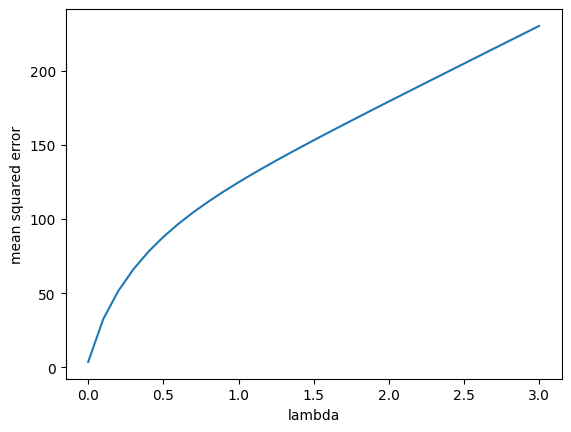

C:\Users\lomin\AppData\Local\Temp\ipykernel_12076\1982064451.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_mse[idx] = curr_rmse


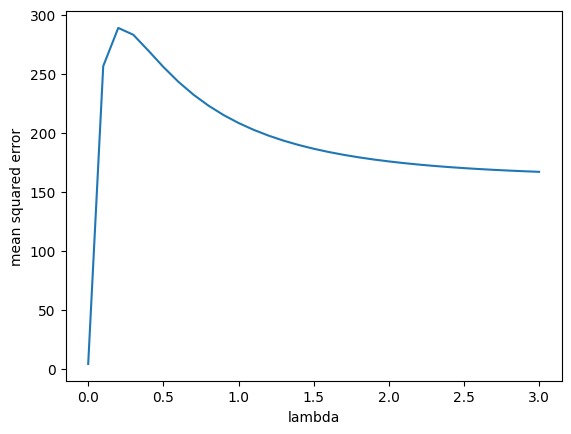

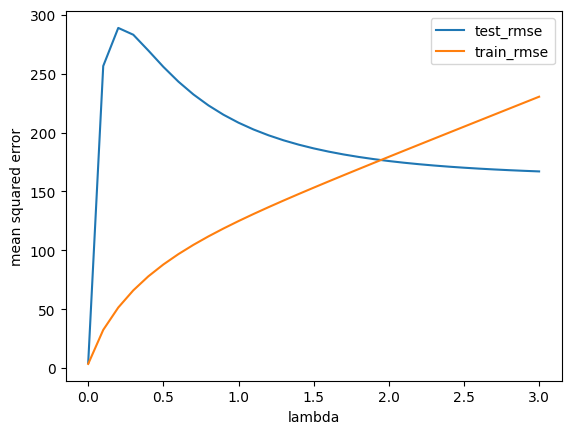

In [172]:
def plot_linear_regression_mean_squared_errors(mean_squared_errors, hyperparams):
    plt.plot(hyperparams, mean_squared_errors)
    plt.ylabel('mean squared error')
    plt.xlabel('lambda')
    plt.show()

# plot results
plot_linear_regression_mean_squared_errors(mean_squared_errors, hyperparams)

test_mse = np.zeros(len(hyperparams))

"""
Write code to find the test MSE for all hyperparameters
"""
X_withBias = create_inputs_with_bias(X_te)
for idx, hyperparam in enumerate(hyperparams):
    w = solve_ridge_regression(X_withBias, y_te, hyperparam)
    y_hat = predict_linear_regression(X_withBias, w)
    curr_rmse = rmse(y_te, y_hat) + hyperparam * (w.transpose().dot(w))
    test_mse[idx] = curr_rmse

plot_linear_regression_mean_squared_errors(test_mse, hyperparams)

plt.plot(hyperparams, test_mse, label="test_rmse")
plt.plot(hyperparams, mean_squared_errors, label="train_rmse")
plt.ylabel('mean squared error')
plt.xlabel('lambda')
plt.legend()
plt.show()


_Type your answer here, replacing this text._

<!-- END QUESTION -->

## **Question 2: Gradient Descent (55 points)**
At this point, we should know how to solve regression tasks using an analytical solution. However, not all types of methods have something nice to calculate like linear or ridge regression. In this section, we'll learn to use _gradient descent_, as you've seen in class, to solve regression tasks.

We'll now use a synthetically generated dataset for this part of the assignment.

In [173]:
def load_gd_data(working_dir):
    test_inputs = np.genfromtxt(working_dir + '/data/test_inputs.csv', delimiter=',')
    test_targets = np.genfromtxt(working_dir + '/data/test_targets.csv', delimiter=',')
    train_inputs = np.genfromtxt(working_dir + '/data/train_inputs.csv', delimiter=',')
    train_targets = np.genfromtxt(working_dir + '/data/train_targets.csv', delimiter=',')

    return train_inputs, train_targets.reshape((train_targets.shape[0], 1)), test_inputs, test_targets.reshape((test_targets.shape[0], 1))

X_tr, y_tr, X_te, y_te = load_gd_data(working_dir)

### Q2a) **(15 points)**
This part of the question will deal with implementing functions that can calculate the gradients that are used during regression.

Along with linear and ridge regression, we introduce LASSO regression, which is similar to ridge regression but instead of using a penalty term of $\|w\|_2^2$, we use a penalty of $\|w\|_1$. Since you might not be familiar with this notation, we denote the function $f(\cdot) = \| \cdot \|_1$ as the L1-norm function, where
$$
\| w \|_1 = |w_1| + |w_2| + \dots + |w_d|
$$

Provide a function that computes the gradient for all three regression types.

In [188]:
def linear_regression_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray, **kwargs) -> np.ndarray:
    """Compute the gradient of w with respect to the loss

    Args:
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]
        w (np.ndarray): Numpy array of shape [features, 1], where the last value is w_0 and all other values represent w_1

    Returns:
        np.ndarray: Gradient of w with respect to the loss, as a numpy array of the same shape as w.
    """
    y_hat = np.dot(X, w)

    gradient =  np.dot(X.transpose(), (y_hat - y)) / X.shape[0]
    
    return gradient


In [189]:
def ridge_regression_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray, hyperparameter: float, **kwargs) -> np.ndarray:
    """Compute the gradient of w with respect to the loss

    Args:
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]
        w (np.ndarray): Numpy array of shape [features, 1], where the last value is w_0 and all other values represent w_1
        hyperparameter (float): Lambda used in L2 regularizer

    Returns:
        np.ndarray: Gradient of w with respect to the loss, as a numpy array of the same shape as w.
    """

    y_hat = np.dot(X, w)
    
    gradient = np.add(np.dot(X.transpose(), (y_hat - y)) / X.shape[0], 2 * hyperparameter * w)

    return gradient

In [190]:
def lasso_regression_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray, hyperparameter: float, **kwargs) -> np.ndarray:
    """Compute the gradient of w with respect to the loss

    Args:
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]
        w (np.ndarray): Numpy array of shape [features, 1], where the last value is w_0 and all other values represent w_1
        hyperparameter (float): Lambda used in L2 regularizer

    Returns:
        np.ndarray: Gradient of w with respect to the loss, as a numpy array of the same shape as w.
    """

    y_hat = np.dot(X, w)
    
    gradient = np.add(np.dot(X.transpose(), (y_hat - y)) / X.shape[0], hyperparameter * np.sign(w))

    return gradient

In [191]:
grader.check("q2.1")

q2.1 results: All test cases passed!

### Q2b) **(15 points)**

Now write a function for solving a given regression task using gradient descent instead of the analytical solution. In this case, the function will take in a parameter `reg_type` to determine the type of regression we're using, a `hyperparameter` in case we are doing regularization, a `learning_rate` parameter which sets the size of the steps we make in the gradient directions and `num_epochs` which defines how many gradient descent steps we wish to perform.

Throughout the process, you should keep track of the training and testing losses (use your functions implemented in the prior question).

In [192]:
def regression_gradient_descent(X_train: np.ndarray, y_train: np.ndarray,
                                X_test: np.ndarray, y_test: np.ndarray,
                                w_0: np.ndarray, hyperparameter: float,
                                learning_rate: float, num_epochs: int, reg_type: str = 'linear') -> Tuple[List[float], List[float], np.ndarray]:
    """ Runs gradient descent to optimize the parameters w.

    Args:
        y_train (np.ndarray): Numpy array of shape [observations, 1]
        X_train (np.ndarray): Numpy array of shape [observations, features]
        X_test (np.ndarray): Numpy array of shape [observations, features]
        y_test (np.ndarray): Numpy array of shape [observations, 1]
        w_0 (np.ndarray): Numpy array of shape [features, 1]
        hyperparameter (float): Lambda used in L2 regularizer
        learning_rate (float): Value to multiply our gradient with before updating our parameters.
        num_epochs (int): Number of gradient descent steps to perform.
        reg_type (str): The type of regression to use ['linear', 'ridge', 'lasso']

    Returns:
        train_loss (np.ndarray): The train RMSE loss without L2 regularizer, for each step.
        val_loss (np.ndarray): The validation RMSE loss without L2 regularizer, for each step.
        optimized_w (np.ndarray): The optimized w parameters.
    """

    valid = {'linear', 'ridge', 'lasso'}
    if reg_type not in valid:
        raise ValueError("Invalid regression type")

    train_losses = np.zeros((num_epochs,), dtype=np.float32)
    test_losses = np.zeros((num_epochs,), dtype=np.float32)
    w_sol = np.copy(w_0)

    for idx in range(num_epochs):
        y_train_hat = predict_linear_regression(X_train, w_sol)
        y_test_hat = predict_linear_regression(X_test, w_sol)

        train_losses[idx] = rmse(y_train, y_train_hat)
        test_losses[idx] = rmse(y_test, y_test_hat)
        
        if(reg_type == "linear"):   w_sol = w_sol - learning_rate * linear_regression_gradient(X_train, y_train, w_sol)
        elif(reg_type == "ridge"):   w_sol = w_sol - learning_rate * ridge_regression_gradient(X_train, y_train, w_sol, hyperparameter)
        elif(reg_type == "lasso"):   w_sol = w_sol - learning_rate * lasso_regression_gradient(X_train, y_train, w_sol, hyperparameter)

    return (train_losses, test_losses, w_sol)

In [193]:
grader.check("q2.2")

q2.2 results: All test cases passed!

### Q2c) **(5 points)**

Now run the above function for both linear and ridge regression. Initialize the initial weight vector using `np.random.normal`.

<!-- BEGIN QUESTION -->

**Your Answer Here**

Write code to find the solution weights for each type of regression. After training each, plot the training and test losses for each regression type to compare learning.

In [194]:
num_epochs = 250
hyperparameter = 0.15
learning_rate = 0.01

# add bias at the end of each data point
train_inputs = create_inputs_with_bias(X_tr)
test_inputs = create_inputs_with_bias(X_te)

w_0 = np.random.normal(size=(train_inputs.shape[1], 1))

"""
Write code here to find the solution for each method.
"""
train_losses, test_losses, w_sol = regression_gradient_descent(train_inputs, y_tr, test_inputs, y_te, w_0, hyperparameter, learning_rate, num_epochs)
train_losses_ridge, test_losses_ridge, w_sol = regression_gradient_descent(train_inputs, y_tr, test_inputs, y_te, w_0, hyperparameter, learning_rate, num_epochs)
train_losses_lasso, test_losses_lasso, w_sol = regression_gradient_descent(train_inputs, y_tr, test_inputs, y_te, w_0, hyperparameter, learning_rate, num_epochs)

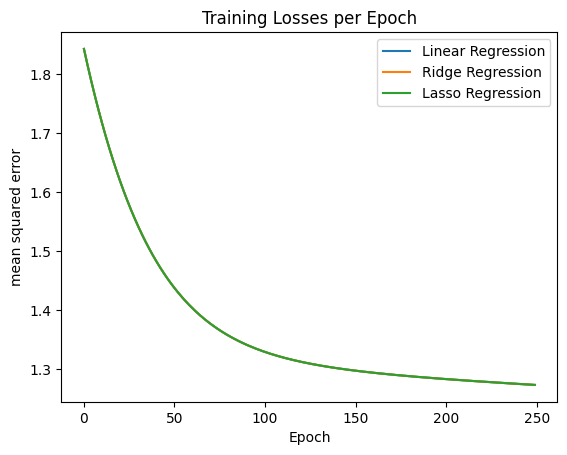

In [195]:
plt.plot(train_losses, label='Linear Regression')
plt.plot(train_losses_ridge, label='Ridge Regression')
plt.plot(train_losses_lasso, label='Lasso Regression')
plt.ylabel('mean squared error')
plt.xlabel('Epoch')
plt.title('Training Losses per Epoch')
plt.legend(loc = 'upper right')
plt.show()

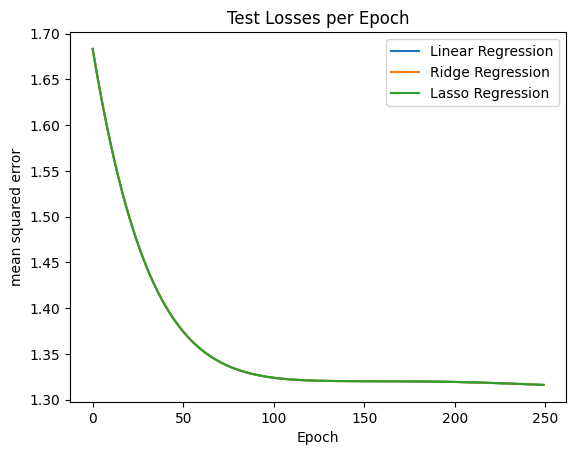

In [196]:
plt.plot(test_losses, label='Linear Regression')
plt.plot(test_losses_ridge, label='Ridge Regression')
plt.plot(test_losses_lasso, label='Lasso Regression')
plt.ylabel('mean squared error')
plt.xlabel('Epoch')
plt.title('Test Losses per Epoch')
plt.legend(loc = 'upper right')
plt.show()

<!-- END QUESTION -->

### Q2d) **(5 points)**

<!-- BEGIN QUESTION -->

In the previous examples, we perform what we call full-batch gradient descent. However, this isn't always realistic, as sometimes there is too much data for this to be feasible on modern computers. In these cases, a more feasible option be to perform batch gradient descent, which is a scenario where we have to take a subset of the whole dataset at each gradient update to get an estimate of the direction of the true gradient.

There is a simple way in which one can use batches to exhibit the exact behaviour as full-batch gradient descent. In less than 100 words, describe it.

We could use the miniBatch Gradient Descent algorithm. Where instead of using all of the N examples to compute the gradient and update w, we only use a subset (batch) of size k (where k << N) of the examples to compute the gradient and update w.

<!-- END QUESTION -->

### Q2e) **(5 points)**
For the following question, we'll change up the data to a new synthetic dataset that was generated by us. We again load the data in the format where each row of $X$ constitutes an example.

In [197]:
def load_comp_data(working_dir):
    test_inputs = np.genfromtxt(working_dir + '/data/X_test_C.csv', delimiter=',')
    test_targets = np.genfromtxt(working_dir + '/data/Y_test_C.csv', delimiter=',')
    train_inputs = np.genfromtxt(working_dir + '/data/X_train_C.csv', delimiter=',')
    train_targets = np.genfromtxt(working_dir + '/data/Y_train_C.csv', delimiter=',')

    return train_inputs, train_targets.reshape((train_targets.shape[0], 1)), test_inputs, test_targets.reshape((test_targets.shape[0], 1))

X_train, y_train, X_test, y_test = load_comp_data(working_dir)

<!-- BEGIN QUESTION -->

Using a $\lambda$ (regularization hyperparameter) of 1 for the regularization coefficient, plot the weight distribution for both ridge and Lasso regression.

What do you notice about the weights and their values? What about the regularization term do you think is causing this and why?

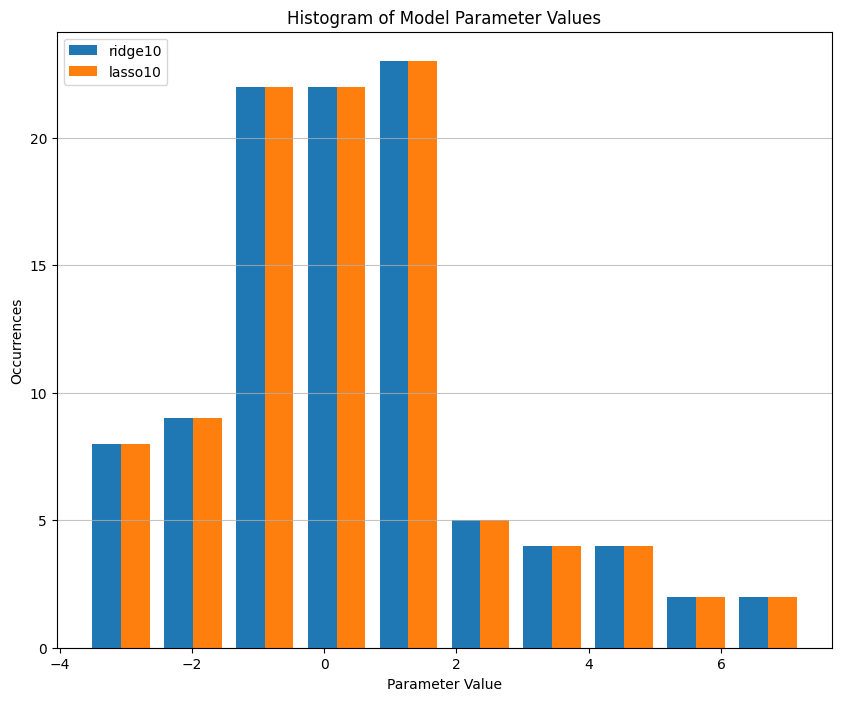

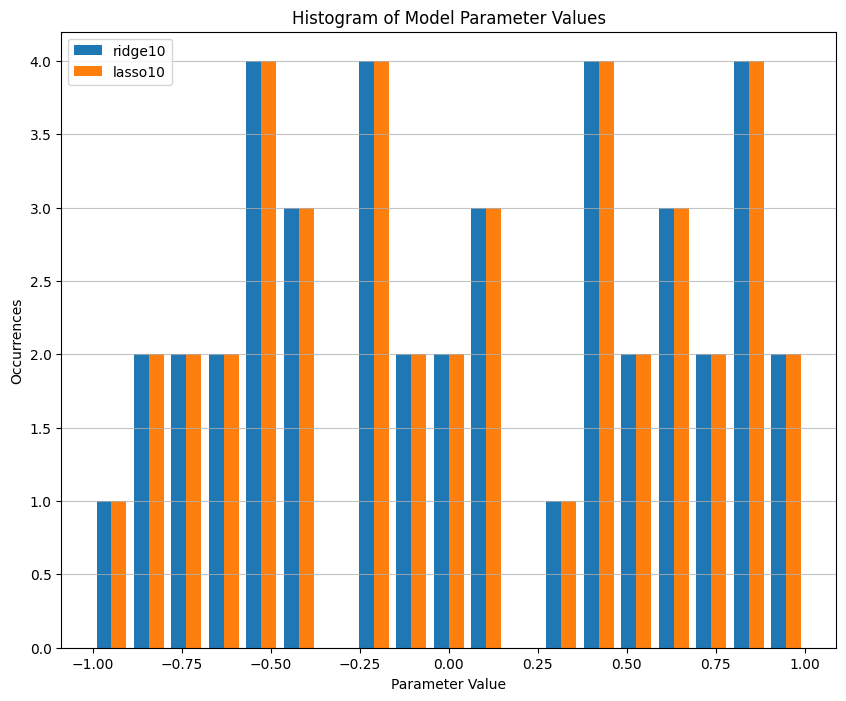

In [198]:
"""
Write code to create the data and then run regression on the two.
"""

train_inputs = create_inputs_with_bias(X_train)
test_inputs = create_inputs_with_bias(X_test)

np.random.seed(8245)
w_0 = np.random.normal(size=(train_inputs.shape[1], 1))

train_losses_ridge, test_losses_ridge, w_sol_ridge = regression_gradient_descent(train_inputs, y_train, test_inputs, y_test, w_0, 1, learning_rate, num_epochs)
train_losses_lasso, test_losses_lasso, w_sol_lasso = regression_gradient_descent(train_inputs, y_train, test_inputs, y_test, w_0, 1, learning_rate, num_epochs)


data = [w_sol_ridge.flatten(), w_sol_lasso.flatten()]
labels = ['ridge10', 'lasso10']
plt.figure(figsize = (10, 8))
plt.hist(data, label=labels)

plt.grid(axis='y', alpha=0.75)
plt.legend(loc = 'upper left')
plt.title('Histogram of Model Parameter Values')
plt.ylabel('Occurrences')
plt.xlabel('Parameter Value')
plt.show()

data = [w_sol_ridge.flatten(), w_sol_lasso.flatten()]
labels = ['ridge10', 'lasso10']

bins = np.linspace(-1, 1, 20)
plt.figure(figsize = (10, 8))
plt.hist(data, bins = bins, label=labels)

plt.grid(axis='y', alpha=0.75)
plt.legend(loc = 'upper left')
plt.title('Histogram of Model Parameter Values')
plt.ylabel('Occurrences')
plt.xlabel('Parameter Value')
plt.show()

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Q2f) **(5 points)**

Provide an intuitive manner to understand why this happens mathematically?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Q2g) **(5 points)**

In Q2d), you derived an algorithm to calculate the full-batch gradient update using only subsets of the data.

Consider the case where you perform a gradient update at every batch. In this case, the direction of the gradient update is only an estimate of the true gradient direction. There is a signficant problem we may face if we were to try using this in our above implementation, in particular our learning rate. Can you think of what it is?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

